### Figure 2: Distribution Plot

In [29]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [30]:
def plot_histogram(real,inputs, pred_cnn,pred_vaegan, pred_dsrnngan, binwidth,alpha,type='Mean'):
        """
        This function plots a histogram of the set in question
        """
        # ax = sns.histplot(data=penguins, x="flipper_length_mm", hue="species", element="step")
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(ax=ax,data=real, stat="density", fill=True,color='#cdeac0',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=inputs, stat="density", fill=True,color='#efe9ae',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_cnn, stat="density", fill=True,color='#fec3a6',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_vaegan, stat="density", fill=True,color='#ff928b',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_dsrnngan, stat="density", fill=True,color='#ffac81',element='step',alpha=alpha)
        ax.set_xlabel('Mean or Peak rainfall (mm/h)',size=18)
        ax.set_xlabel('%s Rainfall (mm/h)' % type,size=18)
        ax.set_ylabel('Density',size=18)
        plt.legend(labels=['real','input','cnn','vaegan','dsrnngan'],fontsize=24)
        plt.show()
        # plt.savefig('figs/histogram_accumulated_%s.png' % mode)

def calc_peak(array):
        nstorms,_,_ = array.shape
        peaks = np.zeros((nstorms))
        for i in range(nstorms):
                peaks[i] = np.nanmax(array[i])
        return peaks

def calc_mean(array):
        nstorms,_,_ = array.shape
        means = np.zeros((nstorms))
        for i in range(nstorms):
                means[i] = np.nanmean(array[i])
        return means

In [31]:

model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]


# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)

(16253, 10, 10)
(16253, 100, 100)


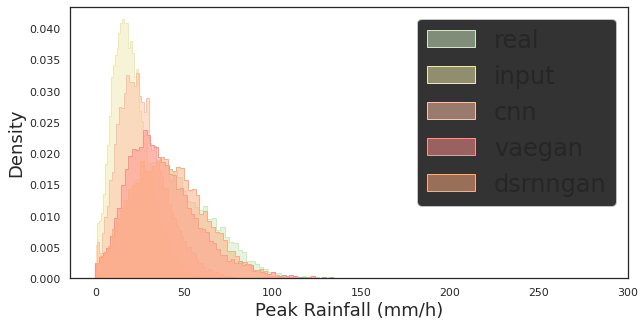

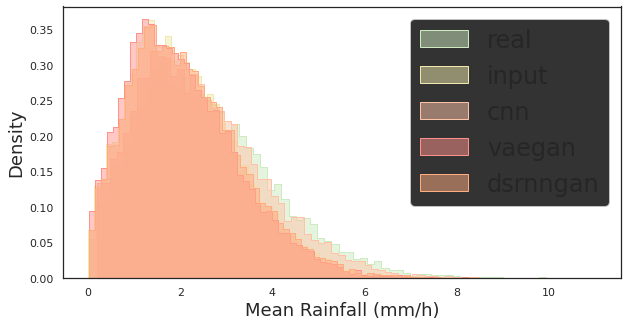

mean real:  2.5540338
mean pred:  2.4462242
std real:  5.023968
std pred:  3.9915657


In [37]:

pred = inputs_hr
def distribution(real,pred):
	peak_reals = calc_peak(real)
	peak_preds = calc_peak(pred_dsrnngan)
	peak_inputs = calc_peak(inputs)
	peak_vaegan = calc_peak(pred_vaegan)
	peak_cnn = calc_peak(pred_cnn)
	# plot_histogram(peak_reals,peak_preds,5,0.5,type = 'Peak')
	plot_histogram(peak_reals,peak_inputs,peak_cnn,peak_vaegan,peak_preds,5,0.5,type = 'Peak')
	# real,inputs, pred_cnn,pred_vaegan, pred_dsrnngan,
	# ks = stats.kstest(peak_reals, peak_preds)
	# print(ks)
	# ks = stats.ks_2samp(peak_reals, peak_preds)
	# print(ks)

	mean_reals = calc_mean(real)
	mean_preds = calc_mean(pred_dsrnngan)
	mean_inputs = calc_mean(inputs)
	mean_vaegan = calc_mean(pred_vaegan)
	mean_cnn = calc_mean(pred_cnn)
	# plot_histogram(mean_reals,mean_preds,5,0.5)
	plot_histogram(mean_reals,mean_inputs,mean_cnn,mean_vaegan,mean_preds,5,0.5)
	# ks = stats.kstest(mean_reals, mean_preds)
	# print(ks)
	# ks = stats.kstest(mean_preds,mean_preds)
	# print(ks)


	print('mean real: ',np.mean(real))
	print('mean pred: ', np.mean(pred))
	print('std real: ',np.std(real))
	print('std pred: ',np.std(pred))
	return peak_reals,peak_preds,peak_inputs,peak_vaegan,peak_cnn

peak_reals,peak_dsrnngan,peak_inputs,peak_vaegan,peak_unet = distribution(real,pred)

g ['A' 'B' 'C' ... 'C' 'D' 'E']
x 81260


AttributeError: 'function' object has no attribute 'scatter'

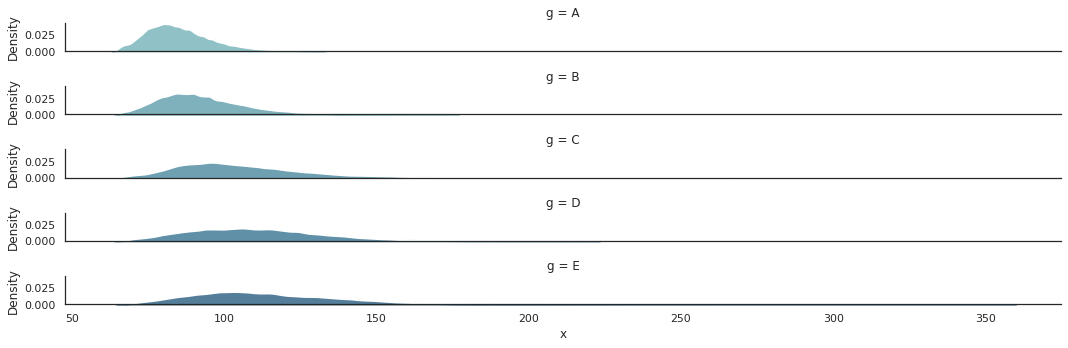

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(250)
x = []
for i in range(len(peak_reals)-1):
      x.append(peak_inputs[i])
      x.append(peak_unet[i])
      x.append(peak_vaegan[i])
      x.append(peak_dsrnngan[i])
      x.append(peak_reals[i])
      
# g = np.tile(['REAL','INPUT','UNET','VAEGAN',"DSRNNGAN"], 50)
g = np.tile(['A','B','C','D','E'], 16252)
print('g',g)
print('x',len(x))
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# add percentiles


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    print(label)
    if label == 'A':
          label = 'INPUTS'
    elif label == 'B':
          label = 'UNET'
    elif label == 'C':
          label = 'VAEGAN'
    elif label == 'D':
          label = 'DSRNNGAN'
    elif label == 'E':
          label = 'REAL'          
    print(color)
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="",xlabel="Peak rainfall (mm/h)")
g.set_xlabels("Peak rainfall (mm/h)",fontweight='bold',color='#425782',size=15)
g.set_xticklabels(size = 12,fontweight='bold',color='#425782')
g.despine(bottom=True, left=True)

In [41]:
print(81260/5)

16252.0
